In [19]:
# original size 258866 # 258841 # 258816
import sys
import os
from torch.utils.data import DataLoader
sys.path.append("..")
from tqdm import tqdm
import shutil
import torch
import numpy as np
import pandas as pd

from utils import train_test_split, create_metadata_df
from dataset_xy import CARLADatasetXY
from data_preprocessing import preprocessing
import json
from send2trash import send2trash

In [20]:
path_data = os.path.join("..", "..", "data", "data")

config_xy = {"used_inputs": ["rgb", "measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "y": ["brake", "steer", "throttle"],
        "seq_len": 1
        }

# Create df_meta 
df_meta_data = create_metadata_df(path_data, config_xy["used_inputs"])

# Create Dataset & DataLoader
dataset = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data, config=config_xy)

In [79]:
dl = DataLoader(dataset=dataset, batch_size=64, num_workers=0, sampler=None, shuffle=False)

In [4]:
df_measurements = pd.read_pickle("measurements_2.pickle")

array([[<AxesSubplot: title={'center': 'speed'}>,
        <AxesSubplot: title={'center': 'command'}>],
       [<AxesSubplot: title={'center': 'steer'}>,
        <AxesSubplot: title={'center': 'throttle'}>],
       [<AxesSubplot: title={'center': 'brake'}>, <AxesSubplot: >]],
      dtype=object)

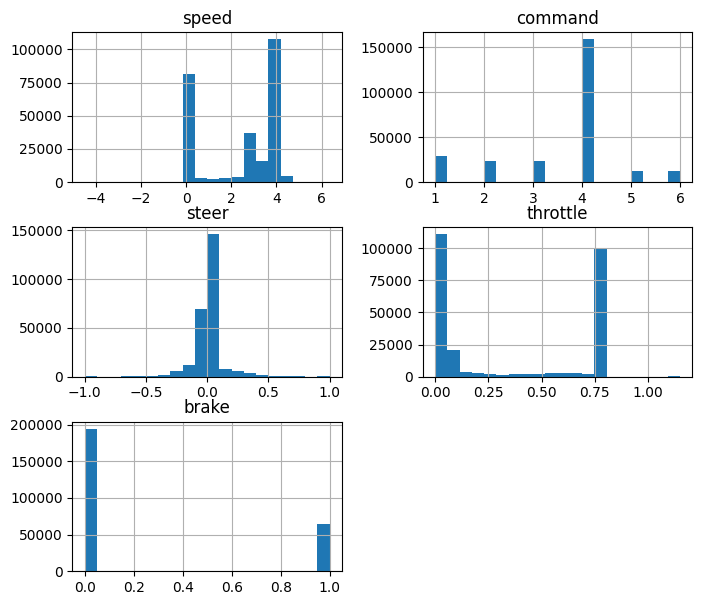

In [82]:
df_measurements.hist(figsize=(8, 7), bins=20)

In [83]:
df_meta_data_train, df_meta_data_test = train_test_split(df_meta_data, towns={"train": ["Town04"], "test": ["Town05"]}) # "Town06"

array([[<AxesSubplot: title={'center': 'speed'}>,
        <AxesSubplot: title={'center': 'command'}>],
       [<AxesSubplot: title={'center': 'steer'}>,
        <AxesSubplot: title={'center': 'throttle'}>],
       [<AxesSubplot: title={'center': 'brake'}>, <AxesSubplot: >]],
      dtype=object)

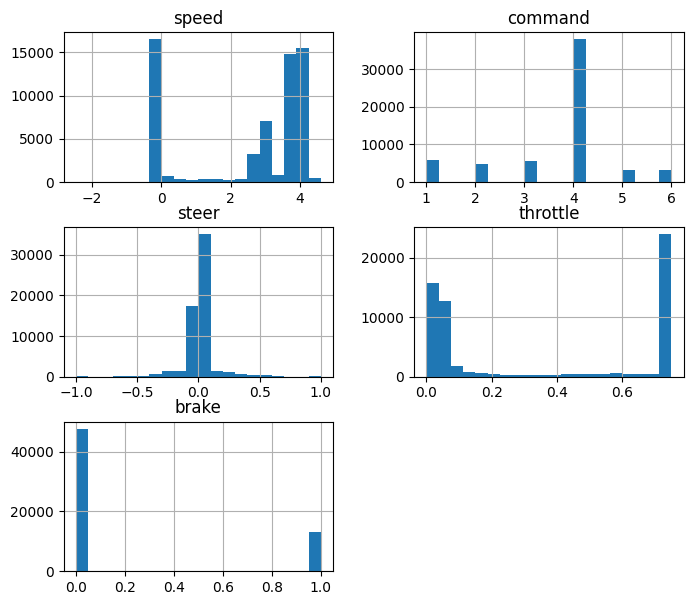

In [91]:
df_measurements_train = df_measurements[df_measurements.index.isin(df_meta_data_train.index)]
df_measurements_train.hist(figsize=(8, 7), bins=20)

array([[<AxesSubplot: title={'center': 'speed'}>,
        <AxesSubplot: title={'center': 'command'}>],
       [<AxesSubplot: title={'center': 'steer'}>,
        <AxesSubplot: title={'center': 'throttle'}>],
       [<AxesSubplot: title={'center': 'brake'}>, <AxesSubplot: >]],
      dtype=object)

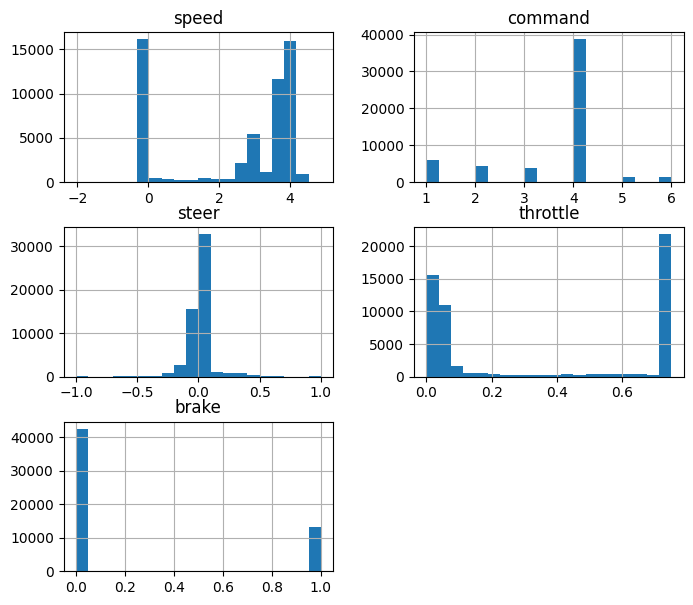

In [92]:
df_measurements_test = df_measurements[df_measurements.index.isin(df_meta_data_test.index)]
df_measurements_test.hist(figsize=(8, 7), bins=20)

In [28]:
freq_classes = {"steer":{
                            "1": (lambda ser: ser.between(-1.1, -0.4, inclusive="left")),
                            "2": (lambda ser: ser.between(-0.4, -0.1, inclusive="left")),
                            "3": (lambda ser: ser.between(-0.1, 0.1, inclusive="left")),
                            "4": (lambda ser: ser.between(0.1, 0.4, inclusive="left")),
                            "5": (lambda ser: ser.between(0.4, 1.1, inclusive="left")),
                        }
                }               

In [ ]:
def steer_classifier(steer):
    if -1 <= steer < -0.4:
        return 1
    elif -0.4 <= steer < -0.1:
        return 2
    elif -0.1 <= steer < 0.1:
        return 3
    elif 0.1 <= steer < 0.4:
        return 4
    elif 0.4 <= steer < 1.1:
        return 5

In [ ]:
df_measurements["steer"].apply(steer_classifier)# .plot(kind="pie")

In [29]:
ser_temp = []
for key_class in freq_classes["steer"]:
    ser = freq_classes["steer"][key_class](df_measurements["steer"])
    ser.name = key_class
    ser_temp.append(ser)

In [30]:
df_classes = pd.concat(ser_temp, axis=1)
df_classes_check = df_classes.sum(axis=1)

In [11]:
df_meta_data.loc[0]["measurements"]

'0000.json'

In [35]:
def remove_entries_at_indices(df_meta_entire):
    idx_nan_list = [6642, 6643, 6644, 6645, 79569, 79570, 79571, 79572, 79653, 79654, 79655, 79656, 79680, 79681, 79682, 79683, 191367, 203112, 203113, 203114, 203115, 222663, 222664, 222665, 222666]
    count_files_deleted = 0
    for idx_nan in idx_nan_list:
        path_nan = os.path.join(df_meta_entire.loc[idx_nan]["dir"], "measurements", df_meta_entire.loc[idx_nan]["measurements"])
        with open(path_nan, 'r') as f:
            measurements = json.load(f)
        if not np.isnan(measurements["steer"]):
            print("Break: indexes do not fit!")
            break
        dir = df_meta_entire["dir"].loc[idx_nan]
        dirs_sensors = os.listdir(dir)
        number_entry = df_meta_entire["measurements"].loc[idx_nan].split(".")[0]
        for dir_sensor in dirs_sensors:
            if not dir_sensor.startswith("."):
                files = os.listdir(os.path.join(dir, dir_sensor))
                for file in files:
                    if file.startswith(number_entry):
                        count_files_deleted += 1
                        # os.remove(os.path.join(dir, dir_sensor, file))
                        send2trash(os.path.join(dir, dir_sensor, file))
    return count_files_deleted

In [23]:
remove_steer_nan_entries(df_meta_data)

Break: indexes do not fit!


0

In [2]:
import numpy as np
np.isnan(np.nan)

True

In [ ]:
 with open(path, 'r') as f:
            measurements = json.load(f)

In [20]:
# df_meta_data.to_pickle("meta_data_entire.pickle")

# Creating classes for continous variables using histograms

In [36]:
hist, bin_edges = np.histogram(df_measurements["steer"], bins=5)
bin_edges[-1] = 1.1

In [48]:
bin_mapping = np.digitize(df_measurements["steer"], bins=bin_edges,)
bin_mapping_count = pd.DataFrame(bin_mapping).value_counts(normalize=True).sort_index()

In [52]:
bin_mapping_weighted = np.zeros(len(bin_mapping))
for idx, bin_map in enumerate(bin_mapping):
    bin_mapping_weighted[idx] = bin_mapping_count.loc[bin_map]

In [54]:
bin_mapping_weighted = 1 / bin_mapping_weighted

In [64]:
# (bin_mapping_weighted / bin_mapping_weighted.sum()).sum() = 1
sample_weights_entire = (bin_mapping_weighted / bin_mapping_weighted.sum())

In [65]:
# (bin_mapping_weighted[:64] / bin_mapping_weighted[:64].sum()).sum() = 1
sample_weights_first_batch = (bin_mapping_weighted[:64] / bin_mapping_weighted[:64].sum())